In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt

# Import the Feedforward-NN
It has to bee a SequentialNN

In [2]:

nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)


"""
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)
"""

"""
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device('cpu')), strict=False)
"""


'\nnn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])\nnn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device(\'cpu\')), strict=False)\n'

In [3]:
parameter_list = list(nn.parameters())
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

# Load the data to apply the verification process for

In [4]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [5]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

# Settings for the optimization 

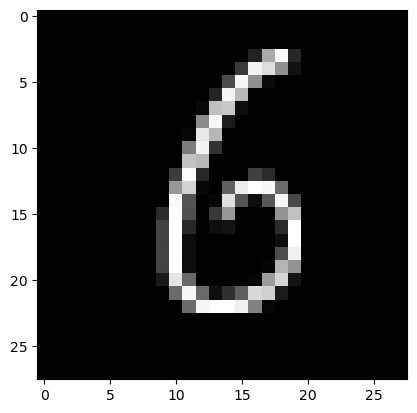

The label is 6
NN classifies image correctly as 6


In [6]:
# image to do the verification for
image_index = 18

# epsilon radius
eps = 0.01

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")


# Add the objective to the optimization problem
in this case we want to find the maximum difference between any one neuron and the target neuron (label)

In [7]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0]
    out_ub = nn_layer_out_bounds[-1][1]
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

# Get the output variables by name 
given the gurobi model, the output size of the NN and the index of output layer

In [8]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [9]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

# Defining function to call Gurobi optimizer

In [10]:
def optimize_model(model, output_vars):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    start = time.time()
    model.update()
    model.optimize()
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

# Calculate box-bounds to provide a rough approximation of NN

In [11]:
input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0].tolist())
print(simple_bounds_affine_out[-1][1].tolist())


[-5.477348126706071, -7.216076099388593, -6.285018169964168, -7.415668461174097, -8.054443483887432, -4.7875797099178214, -1.1076350862125812, -11.812239661344467, -6.835572317900799, -7.659874340703596]
[5.841591590613943, 4.990913790180329, 6.691910479448406, 5.323376278516484, 5.942281549316645, 9.522920934119444, 10.692960907923627, 0.8866299674082754, 7.305939813246016, 5.891986807185678]


# Do Single-Neuron-Verification

In [12]:
t = time.time()

# define the Verifier
snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)

# generate the constraints
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()

# add the objective to the gurobi model
snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars, sovler_bound=None)
print("constraint generation time: {}".format(time.time() - t))

print("start with optimization")
optimize_model(snv_model, snv_out_vars)

Restricted license - for non-production use only - expires 2025-11-24
================ layer 0 ===============
================ layer 1 ===============
        0, lower: new 1.7780102316626705, old 0.7785229410209529
        0, upper: new 2.38061044475747, old 3.382789763165622
        1, lower: new 0.9051970207948512, old 0.0703350453951872
        1, upper: new 1.3938053715562926, old 2.231393805514451
        2, lower: new 1.2094718141617322, old 0.40049262989614665
        2, upper: new 1.6868132216227312, old 2.502158267327797
        3, lower: new -0.795149786619982, old -1.4328397004662712
        3, upper: new -0.5075737257378682, old 0.12215092190128374
        4, lower: new 2.585093079626704, old 1.586515229174677
        4, upper: new 3.2116858597195392, old 4.234114368677177
        5, lower: new 0.20426820929029266, old -0.6642235278820858
        5, upper: new 0.6634894025427365, old 1.5202342137261766
        6, lower: new -0.8223003511265674, old -1.8111264454916753
   

True

# Do MILP-Verification if wanted

In [13]:
if use_milp:
    # define the Verifier
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    
    # generate the constraints
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    
    # add the objective to the gurobi model
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

# Attempt verification using DHOV
See MultiDHOV.py and ICNNFactory.py for detailed documentation about the parameters

In [20]:
from script.DHOV.SamplingStrategy import PerGroupSamplingStrategy, PerGroupFeasibleSamplingStrategy, UniformSamplingStrategy
center = torch.flatten(torch_image)
sampling_strategy = PerGroupFeasibleSamplingStrategy(center, eps, keep_ambient_space=True, sample_new=False, sample_count=1000)
# number of neurons which are in one group
group_size = 20

# number of data points which are generated to train the ICNN on
sample_count = 50

# method of sampling data points
sampling_method = "per_group_sampling"

# Size of each layer of the ICNN except for the input layer. (given by group size)
net_size = [5, 1]

# picking the typ of ICNN to use
icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
#icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)

overall_time = time.time()
dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                 icnn_batch_size=10000, use_over_approximation=True, break_after=None,
                                 tighten_bounds=True,
                                 use_fixed_neurons_in_grouping=False, layers_as_snr=[], layers_as_milp=[3],
                                 force_inclusion_steps=3, preemptive_stop=True,
                                data_grad_descent_steps=0, opt_steps_gd=100,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False, print_last_loss=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included", sampling_strategy=sampling_strategy)
print("overall time: {}".format(time.time() - overall_time))


approximation of layer: 0
    number of fixed neurons for current layer: 88
        overall time for feasible test: 1.8384065628051758
        time for only feasible points: 0
    layer progress, group 1 of 1 


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

# Getting an overview over what DHOV has done
show the neuron groups created by DHOV for each layer by index

In [15]:
for i, groups_in_layer in enumerate(dhov_verifier.all_group_indices):
    print(f"Layer {i}")
    for k, group in enumerate(groups_in_layer):
        print(f"    Group {k}: {group}")

Layer 0
    Group 0: [4, 5, 9, 11, 17, 21, 26, 38, 45, 71, 80, 98]
Layer 1
    Group 0: [12, 16, 25]


show the output bounds for the NN. Hopefully these are better than the box-bounds and the bounds obtained by the Single-Neuron-Verification

In [16]:
print(dhov_verifier.bounds_affine_out[-1][0].tolist())
print(dhov_verifier.bounds_affine_out[-1][1].tolist())

[-5.477348126706071, -7.216076099388593, -6.285018169964168, -7.415668461174097, -8.054443483887432, -4.7875797099178214, -1.1076350862125812, -11.812239661344467, -6.835572317900799, -7.659874340703596]
[5.841591590613943, 4.990913790180329, 6.691910479448406, 5.323376278516484, 5.942281549316645, 9.522920934119444, 10.692960907923627, 0.8866299674082754, 7.305939813246016, 5.891986807185678]


# Starting the optimization process

In [17]:
# make changes on a copy of the gurobi model generated by DHOV
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [18]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars, sovler_bound=10)

In [19]:
optimize_model(dhov_model, dhov_out_vars)

var 0: -0.1605842467429106
var 1: -1.0267577066988904
var 2: -0.7817017489425595
var 3: -1.2054562475151096
var 4: -1.1728186110856544
var 5: 3.367321164189698
var 6: 4.802988739995333
var 7: -5.70006718352845
var 8: 0.618789908569247
var 9: -0.7820609982013185
property verified with max difference -1.4356675758056348


True